In [1]:
import requests
import urllib
import urllib2
import community
import re
import networkx as nx
import matplotlib.pyplot as plt

## Retrieving the links for all the characters

In [2]:
# Query components
wikia = "http://lotr.wikia.com/"
api = "api.php?"
action = "action=query"
titles = ""
proprev = "&prop=revisions&rvprop=content"

In [3]:
# URL for retrieving all the characters
url = "http://lotr.wikia.com/api/v1/Articles/List&expand=1&category=Characters&limit=10000"

# Getting the response from the URL and the JSON
r = requests.get(url)
response = r.json()

allUrls = []

# Adding to the URLs list and cleaning the data
for i in range(0, len(response['items'])):
    u = response['items'][i]['url']
    if "Category" not in u:
        allUrls.append(u)

#allUrls = allUrls[5:]
newOne = []
for au in allUrls:
    newOne.append(au.replace("/wiki/",""))

In [6]:
# Storing all the links
allLinks = []
for nextUrl in newOne:
    allLinks.append(wikia+api+action+"&titles="+nextUrl+proprev)

## Filtering and cleaning the data

In [7]:
# Getting all the links for each character and writing them on file
index = 0
tempList = []
racesSet = set()
i = 0
namesAndRaces = []
for link in allLinks:
    # Opening file in Write mode
    #f = open("CharactersLinks/c"+str(index)+".txt", "w")
    # Reading the content of the link given
    
    # Parsing the data filtering the characters that have their race specified.
    m = urllib.urlopen(link.encode('utf-8')).read()
    a = m.split('\n')
    for line in a:
        if "|race" in line or "| race" in line or "|Race" in line or "| Race" in line:
            r = re.findall(r'\[\[(.*?)\]\]', line)
            if len(r) > 0:
                e = r[0]
                namesAndRaces.append([newOne[i].encode('utf-8'),e])
                racesSet.add(e)
            break
            
    
    # Parsing the content of the link looking for links
    links = re.findall(r'\[\[(.*?)\]\]', m)
    i += 1

print "Number of races:",len(racesSet)

Number of races: 40


In [8]:
# Saving the names and races set
temp = namesAndRaces

In [9]:
# Cleaning the data and grouping the races which are written in different ways but which indicate the same race.
for i in namesAndRaces:
    if "Dwarven" in i[1] or "Dwarf" in i[1]:
        i[1] = "Dwarves"
        if "Dwarven" in racesSet or "Dwarf" in racesSet:
            racesSet.remove("Dwarven")
            racesSet.remove("Dwarf")
    if "Hobbit" in i[1] or "Hobbits|Hobbit" in i[1]:
        i[1] = "Hobbits"
        if "Hobbit" in racesSet:
            racesSet.remove("Hobbit")
        if "Hobbits|Hobbit" in racesSet:
            racesSet.remove("Hobbits|Hobbit")
    if "Dragon" in i[1]:
        i[1] = "Dragons"
        if "Dragon" in racesSet:
            racesSet.remove("Dragon")
    if "Man" in i[1]:
        i[1] = "Men"
        if "Man" in racesSet:
            racesSet.remove("Man")
    if "File" in i[1]:
        toDelete = i
    if "Orc" in i[1]:
        i[1] = "Orcs"
        if "Orc" in racesSet:
            racesSet.remove("Orc")
    if "Elf" in i[1]:
        i[1] = "Elves"
        if "Elf" in racesSet:
            racesSet.remove("Elf")

if toDelete in namesAndRaces:
    namesAndRaces.remove(toDelete)

In [10]:
# Parameters for the queries.
wikia = "http://lotr.wikia.com/"
api = "api.php?"
action = "action=query"
titles = ""
prop = "links"
proprev = "rvprop=content"

In [11]:
# Building all the links where to take the references to other articles from.
myLinks = []
for nextName in newOne:
    myLinks.append(wikia+api+action+"&titles="+nextName+"&"+"prop="+prop+"&"+proprev+"&pllimit=500&format=json")

In [12]:
#index = 0
#for link in myLinks:
   # r = requests.get(link)
    #response = r.json()
  #  rep = response['query']['pages'].values()[0]
   # if "/" not in newOne[index] and ":" not in newOne[index]:
    #    f = open("NewCharsLinks/"+str(newOne[index])+".txt", "w")
     #   if 'links' in rep:
      #      linksInPage = rep.get('links')
       #     for l in linksInPage:
        #        charName = l['title']
         #       charName = charName.encode('utf-8')
          #      charName = charName.replace(" ", "_")
           #     f.write(charName+"\n")
#        f.close()
 #   index+=1

## Building the Network

* First of all, let's visualize the entire graph retrieved from the Wikia.

In [13]:
# New Directed Graph
index = 0
G2 = nx.DiGraph()
tempG = nx.DiGraph()

# Adding the nodes to the graph
for n in namesAndRaces:
    G2.add_node(n[0])
    
count = 0

# Linking the nodes. If a character's file has a reference to another character, we look for the node with that 
# name and we link the two nodes with an edge.
for fileNumber in range(0, len(namesAndRaces)):
    if "/" not in namesAndRaces[fileNumber][0] and ":" not in namesAndRaces[fileNumber][0]:
        f = open("NewCharsLinks/"+str(namesAndRaces[fileNumber][0])+".txt", "r")
        charLinks = f.read().split("\n")

        for link in charLinks:
            # Cleaning the item
            link = link.replace("\r","")
            for name in namesAndRaces:
                if link == name[0]:
                    firstChar = namesAndRaces[fileNumber][0]
                    secondChar = link
                    c1 = ""
                    c2 = ""
                    for i in G2.nodes():
                        if i == firstChar:
                            c1 = i
                        elif i == secondChar:
                            c2 = i
                    G2.add_edge(c1, c2)


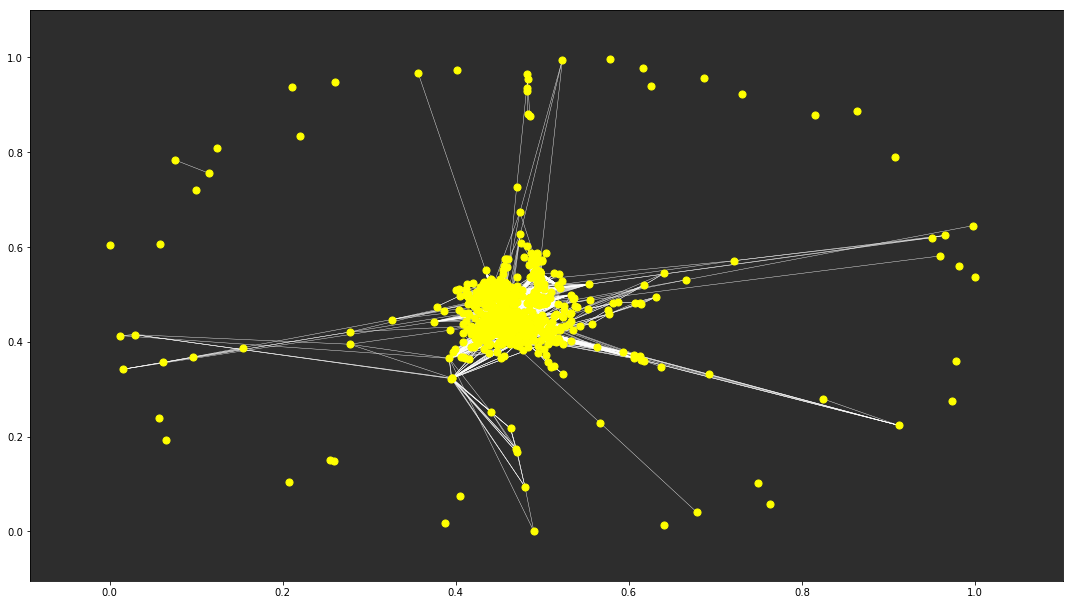

In [14]:
# Drawing the graph with a spring_layout
pos = nx.spring_layout(G2)
nx.draw_networkx_nodes(G2, pos, node_color = 'yellow', node_size = 50, width=100)
nx.draw_networkx_edges(G2, pos, edge_color= 'white', arrows=False, width=0.4)
ax = plt.subplot()
ax.set_facecolor((0.176470588, 0.176470588,0.176470588))
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
fig.savefig('newGraph.pdf', dpi=100)
plt.show()

In [26]:
# Function which draws the graph with specific colors and labels per node.
def drawCustomGraph(g):
    pos = nx.spring_layout(g,k=0.30,iterations=70, scale=2)
    
    nx.draw_networkx_nodes(g,pos=pos,nodelist=halfeleven, node_color='blue', label='Half-Elven', node_size=17)
    nx.draw_networkx_nodes(g,pos=pos,nodelist=horse, node_color='green', label='Horses',node_size=17)
    nx.draw_networkx_nodes(g,pos=pos,nodelist=hobbits, node_color='red', label='Hobbits',node_size=17)
    nx.draw_networkx_nodes(g,pos=pos,nodelist=urukhai, node_color='yellow', label='Uruk-Hai',node_size=17)
    nx.draw_networkx_nodes(g,pos=pos,nodelist=god, node_color='purple', label='God',node_size=17)
    nx.draw_networkx_nodes(g,pos=pos,nodelist=vampire, node_color='grey', label='Vampires',node_size=17)
    nx.draw_networkx_nodes(g,pos=pos,nodelist=eagles, node_color='orange', label='Eagles',node_size=17)
    nx.draw_networkx_nodes(g,pos=pos,nodelist=blackuruk, node_color='black', label='Black Uruk',node_size=17)
    nx.draw_networkx_nodes(g,pos=pos,nodelist=men, node_color='pink', label='Men',node_size=17)
    nx.draw_networkx_nodes(g,pos=pos,nodelist=ainur, node_color='turquoise', label='Ainur',node_size=17)
    nx.draw_networkx_nodes(g,pos=pos,nodelist=goblin, node_color='crimson', label='Goblins',node_size=17)
    nx.draw_networkx_nodes(g,pos=pos,nodelist=skinchanger, node_color='indigo', label='Skin-Changer',node_size=17)
    nx.draw_networkx_nodes(g,pos=pos,nodelist=greateagles, node_color='magenta', label='Great Eagles',node_size=17)
    nx.draw_networkx_nodes(g,pos=pos,nodelist=maiar, node_color='navy', label='Maiar',node_size=17)
    nx.draw_networkx_nodes(g,pos=pos,nodelist=orcs, node_color='violet', label='Orcs',node_size=17)
    nx.draw_networkx_nodes(g,pos=pos,nodelist=werewolves, node_color='teal', label='Werewolves',node_size=17)
    nx.draw_networkx_nodes(g,pos=pos,nodelist=druedain, node_color='snow', label='Druedain',node_size=17)
    nx.draw_networkx_nodes(g,pos=pos,nodelist=unknown, node_color='silver', label='Unknown',node_size=17)
    nx.draw_networkx_nodes(g,pos=pos,nodelist=uruoloki, node_color='salmon', label='Uruloki',node_size=17)
    nx.draw_networkx_nodes(g,pos=pos,nodelist=stonetrolls, node_color='maroon', label='Stone-Trolls',node_size=17)
    nx.draw_networkx_nodes(g,pos=pos,nodelist=dwarves, node_color='brown', label='Dwarves',node_size=17)
    nx.draw_networkx_nodes(g,pos=pos,nodelist=balrog, node_color='lime', label='Balrog',node_size=17)
    nx.draw_networkx_nodes(g,pos=pos,nodelist=dragons, node_color='gold', label='Dragons',node_size=17)
    nx.draw_networkx_nodes(g,pos=pos,nodelist=ents, node_color='ivory', label='Ents',node_size=17)
    nx.draw_networkx_nodes(g,pos=pos,nodelist=greatspiders, node_color='fuchsia', label='Great Spiders',node_size=17)

    nx.draw_networkx_edges(g, pos, edge_color='white', width=0.1)

    plt.legend()
    

    # Saving graph in the main folder of the project
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    fig.savefig('newGraph.pdf', dpi=100)

    plt.show()
    

In [16]:
# Function to color the legend text
def colorLegendText():
    l = plt.legend()
    for text in l.get_texts():
        text.set_color("white")

* Let's now draw the undirected version of the graph coloring the nodes depending on the race associated to a specific character.

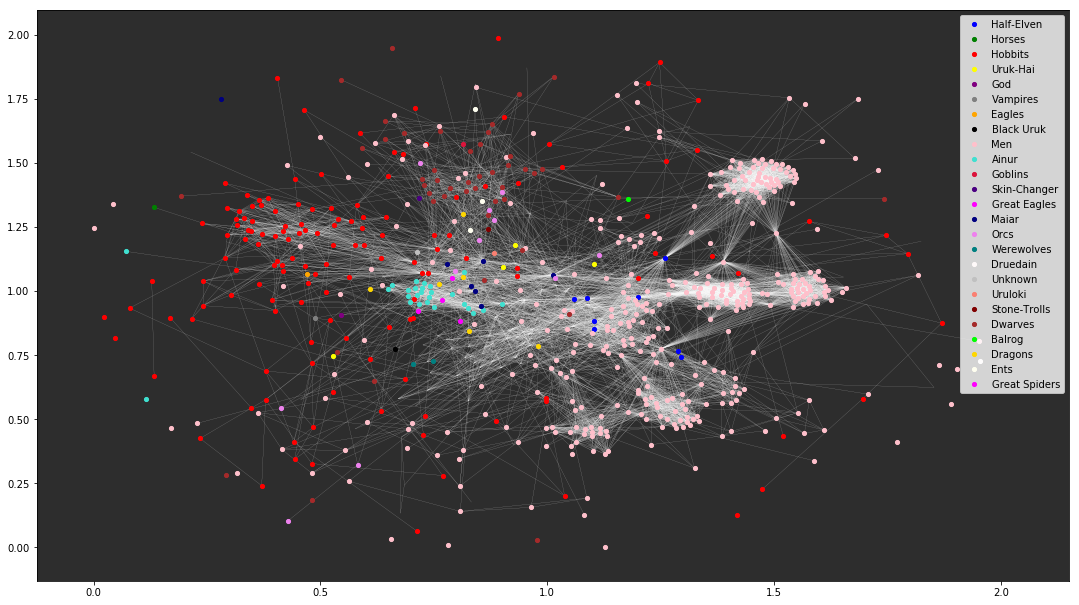

In [27]:
# Getting the undirected version of the graph for further analysis
UG2 = G2.to_undirected()

# Lists which are needed to color and describe the races through a legend.
halfeleven = []
horse = []
hobbits = []
urukhai = []
god = []
vampire = []
eagles = []
blackuruk = []
men = []
ainur = []
goblin = []
skinchanger = []
greateagles = []
maiar = []
orcs = []
werewolves = []
druedain = []
unknown = []
uruoloki = []
stonetrolls = []
dwarves = []
balrog = []
dragons = []
ents = []
greatspiders = []

color_map = []

# Setting up the color map and the races lists for the legend.
for node in UG2:
    for item in namesAndRaces:
        if item[0] == node:
            if item[1] == "Half-elven":
                color_map.append("blue")
                halfeleven.append(node)
            elif item[1] == "Horse":
                color_map.append("green")
                horse.append(node)
            elif item[1] == "Hobbits":
                color_map.append("red")
                hobbits.append(node)
            elif item[1] == "Uruk-hai":
                color_map.append("yellow")
                urukhai.append(node)
            elif item[1] == "God":
                color_map.append("purple")
                god.append(node)
            elif item[1] == "Vampire":
                color_map.append("grey")
                vampire.append(node)
            elif item[1] == "Eagles":
                color_map.append("orange")
                eagles.append(node)
            elif item[1] == "Black Uruk":
                color_map.append("black")
                blackuruk.append(node)
            elif item[1] == "Men":
                color_map.append("pink")
                men.append(node)
            elif item[1] == "Ainur":
                color_map.append("turquoise")
                ainur.append(node) 
            elif item[1] == "Goblin":
                color_map.append("crimson")
                goblin.append(node)
            elif item[1] == "Skin-changer":
                color_map.append("indigo")
                skinchanger.append(node)
            elif item[1] == "Great Eagles":
                color_map.append("magenta")
                greateagles.append(node)
            elif item[1] == "Maiar":
                color_map.append("navy")
                maiar.append(node)
            elif item[1] == "Orcs":
                color_map.append("violet")
                orcs.append(node)
            elif item[1] == "Werewolves":
                color_map.append("teal")
                werewolves.append(node)
            elif item[1] == "Drúedain":
                color_map.append("snow")
                druedain.append(node)
            elif item[1] == "Theories about Tom Bombadil|Unknown":
                color_map.append("silver")
                unknown.append(node)
            elif item[1] == "Urulóki":
                color_map.append("salmon")
                uruoloki.append(node)
            elif item[1] == "Stone-trolls":
                color_map.append("maroon")
                stonetrolls.append(node)
            elif item[1] == "Dwarves":
                color_map.append("brown")
                dwarves.append(node)
            elif item[1] == "Balrog":
                color_map.append("lime")
                balrog.append(node)
            elif item[1] == "Dragons":
                color_map.append("gold")
                dragons.append(node)
            elif item[1] == "Ents":
                color_map.append("ivory")
                ents.append(node)
            elif item[1] == "Great Spiders":
                color_map.append("fuchsia")
                greatspiders.append(node)
        
# Drawing the graph
drawCustomGraph(UG2)
ax = plt.subplot()
ax.set_facecolor((0.176470588, 0.176470588,0.176470588))


* Let's retrieve the GCC first, then let's draw it.

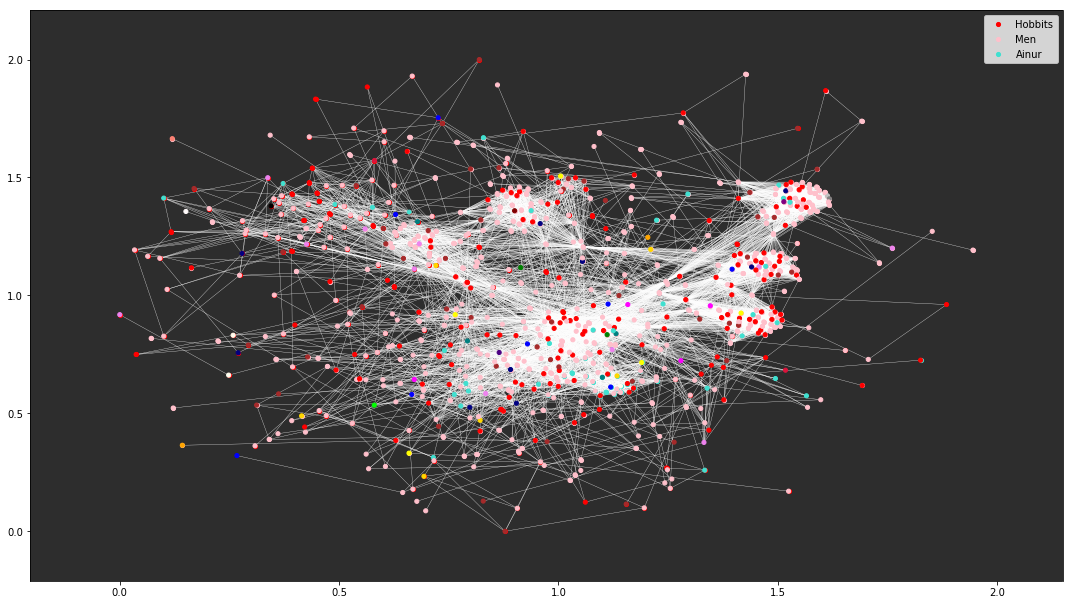

In [23]:
# Retrieving the GCC from UG2
GCC2 = max(nx.connected_component_subgraphs(UG2), key=len)

# Initializing the layout with specific settings as parameters
pos = nx.spring_layout(GCC2,k=0.30,iterations=70, scale=2)

# Lists used to have labels only for Hobbits, Men and Ainurs.
hbs = []
men2 = []
ainurs = []
for hobbit in hobbits:
    if hobbit in GCC2:
        hbs.append(hobbit)
for m in men:
    if m in GCC2:
        men2.append(m)
for ain in ainur:
    if ain in GCC2:
        ainurs.append(ain)

# Drawing the nodes.
nx.draw_networkx_nodes(GCC2,pos=pos,nodelist=hbs, node_color='red', label='Hobbits',node_size=17)
nx.draw_networkx_nodes(GCC2,pos=pos,nodelist=men2, node_color='pink', label='Men',node_size=17)
nx.draw_networkx_nodes(GCC2,pos=pos,nodelist=ainurs, node_color='turquoise', label='Ainur',node_size=17)
nx.draw_networkx_nodes(GCC2, pos,node_color=color_map,with_labels=True, node_size=17) #node_color=color_map, with_labels=True, node_size=17)

# Drawing the legend.
plt.legend()

# Drawing the edges.
nx.draw_networkx_edges(GCC2, pos, edge_color="white",width=0.3)

# Saving graph in the main folder of the project with specific resolution and size.
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
fig.savefig('graphGCC.png', dpi=100)
ax = plt.subplot()
ax.set_facecolor((0.176470588, 0.176470588,0.176470588))

# Showing the graph.
plt.show()

* Let's retrieve the top 50 characters depending on the degree associated to them, and let's draw the graph which connects them. Furthermore, we are going to increase each node's size depending on its degree.

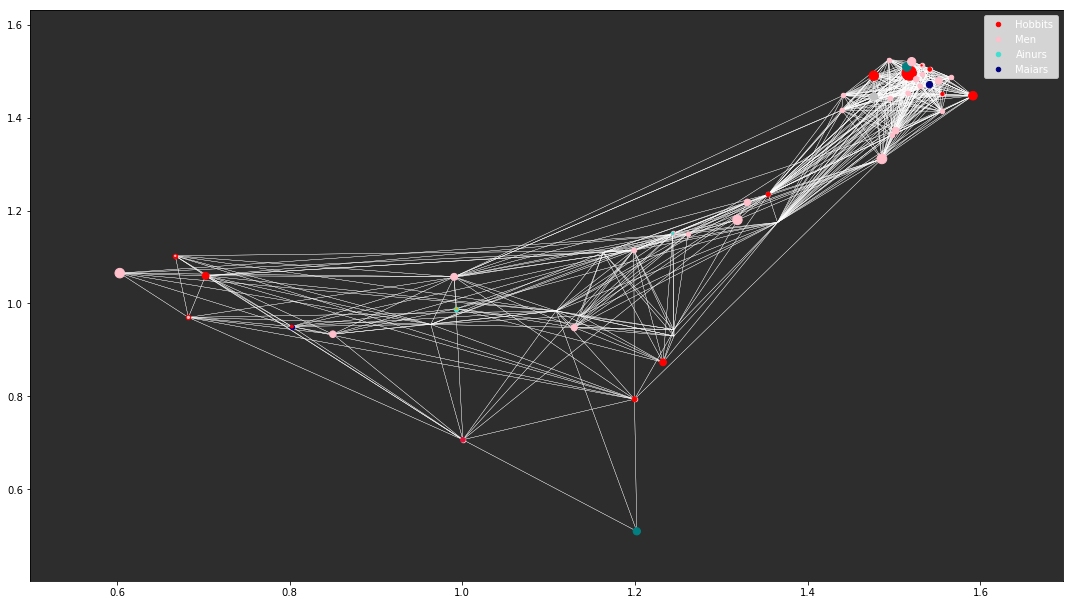

In [20]:
# Drawing the graph in a different way: this time, the nodes are going to be drawn with a size which depends
# on their degree. Furthermore, we are going to consider only the top 50 most important characters based on their
# degrees.

# Dictionary which will contain {character : degree}
mostFamousChars = {}

# Filling the dictionary
for i in GCC2.nodes():
    mostFamousChars[i] = GCC2.degree(i)

# Sorting the characters depending on the degree and limiting the selection to the first 50 ones.
mostFamousChars = sorted(mostFamousChars, key=mostFamousChars.get, reverse=True)[:50]

# We are now going to filter the nodes considering the fact that we want to show only the edges between these
# 50 characters.
el = []
found = False

for m in mostFamousChars:
    for edge in GCC2.edges():
        # Checking if the current node is involved in at least one relationship with another within the top 50.
        if edge[0] == m and edge[1] in mostFamousChars:
            el.append((m, edge[1]))
            found = True
        elif edge[1] == m and edge[0] in mostFamousChars:
            el.append((edge[0],m))
            found = True
    if found == False:
        # If a character doesn't have any relationship with any node in the top 50 collection, then we remove it
        mostFamousChars.remove(m)
    found = False

pos = nx.spring_layout(GCC2,k=0.30,iterations=70, scale=2)

h2 = []
m2 = []
a2 = []
maia2 = []

# Collecting the only nodes which appear in the most famous ones collection.
for h in hbs:
    if h in mostFamousChars:
        h2.append(h)

for m in men2:
    if m in mostFamousChars:
        m2.append(m)

for a in ainurs:
    if a in mostFamousChars:
        a2.append(a)
        
for ma in maiar:
    if ma in mostFamousChars:
        maia2.append(ma)
        
comb = h2+m2+a2+maia2

# Drawing the network with a legend provided
nx.draw_networkx_nodes(GCC2, pos=pos, nodelist=h2, node_color='red', label='Hobbits', node_size=20)
nx.draw_networkx_nodes(GCC2, pos=pos, nodelist=m2, node_color='pink', label='Men', node_size=20)
nx.draw_networkx_nodes(GCC2, pos=pos, nodelist=a2, node_color='turquoise', label='Ainurs', node_size=20)
nx.draw_networkx_nodes(GCC2, pos=pos, nodelist=maia2, node_color='navy', label='Maiars', node_size=20)
nx.draw_networkx_nodes(GCC2, pos=pos, nodelist=comb, node_color=color_map,with_labels=True, node_size=[v * 1.6 for v in allDegreesDiGraph.values()]) #node_color=color_map, with_labels=True, node_size=17)

nx.draw_networkx_edges(GCC2, pos, edgelist=el, edge_color="white",width=0.3)



# Saving graph in the main folder of the project
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
fig.savefig('graphNodesDegree3.png', dpi=100)

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Customizing the background color
ax = plt.subplot()
ax.set_facecolor((0.176470588, 0.176470588,0.176470588))

# Coloring the text within the legend
colorLegendText()

# Showing the graph
plt.show()

* Finally, let's draw the GCC by applying the same concept as before, that is increasing each node's size depending on its degree.

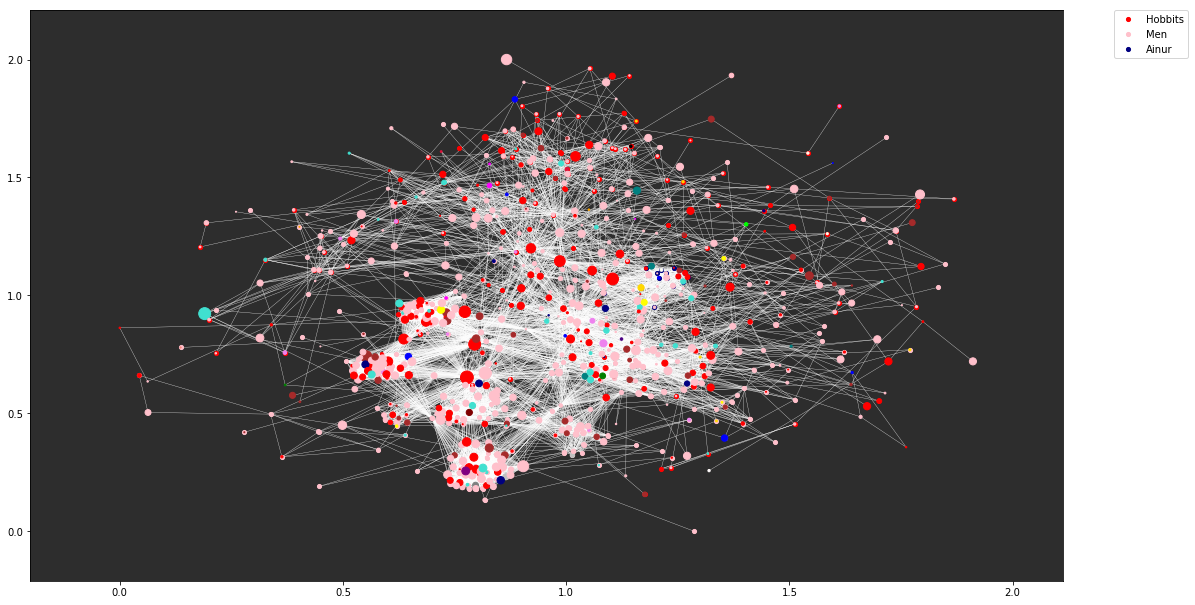

In [22]:
# Getting the degrees of each node
allDegreesDiGraph = nx.degree(GCC2)

# Initializing layout
pos = nx.spring_layout(GCC2,k=0.30,iterations=70, scale=2)

# Drawing the graph
nx.draw_networkx_nodes(GCC2,pos=pos,nodelist=hbs, node_color='red', label='Hobbits',node_size=17)
nx.draw_networkx_nodes(GCC2,pos=pos,nodelist=men2, node_color='pink', label='Men',node_size=17)
nx.draw_networkx_nodes(GCC2,pos=pos,nodelist=ainurs, node_color='navy', label='Ainur',node_size=17)

nx.draw_networkx_nodes(GCC2, pos,node_color=color_map,with_labels=True, node_size=[v * 1.1 for v in allDegreesDiGraph.values()]) #node_color=color_map, with_labels=True, node_size=17)
nx.draw_networkx_edges(GCC2, pos, edge_color="white", width=0.3)

plt.legend()

# Saving graph in the main folder of the project
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
fig.savefig('graphIncreasedSize.png', dpi=100)

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Customizing the background color
ax = plt.subplot()
ax.set_facecolor((0.176470588, 0.176470588,0.176470588))


# Showing the graph
plt.show()

## Further analysis:

* Communities detection and modularity through the Louvain algorithm.

In [ ]:
# Compute the best partition. 
partition = community.best_partition(GCC2)

# Printing out the modularity of the best partition retrieved
print "Modularity retrieved by the Louvain Algorithm: ",community.modularity(partition,GCC2)

# Printing the number of communities.
print "Number of communities:",float(len(set(partition.values()))) 

In [ ]:
# Instantiating an empty dictionary for the races
communities = {}
# Instantiating an empty list 
newList = []
# Grouping all the characters belonging to different communities 
for i,j in partition.iteritems():
    if j not in communities:
        communities[j] = []
    else:
        currentList = communities.get(j)
        currentList.append(i)
        communities[j] = currentList


In [ ]:
# Retrieving the most populated character and printing out the characters in it.
mostPopulated = max([(k, len(v)) for (k,v) in communities.items()], key=lambda (k,v): v)[0]
print "Most populated community:", mostPopulated,"\n"

* Find the top 10 characters by In-Degree and Out-Degree.

In [ ]:
# Let's find the top 10 characters by in-degree first, and then by out-degree.
allInDegree = {}
allOutDegree = {}

# Getting the in-degrees and out-degrees for each node
for char in G2.nodes():
    allInDegree[char] = G2.in_degree(char)
    allOutDegree[char] = G2.out_degree(char)

# Sorting the dictionaries depending the the in-degree and out-degree values
sortedIn = sorted(allInDegree, key=allInDegree.get, reverse=True)[:10]
sortedOut = sorted(allOutDegree, key=allOutDegree.get, reverse=True)[:10]
print "Top 10 by In-Degree:"
for s in sortedIn:
    print s
print "\nTop 10 by Out-Degree:"
for s in sortedOut:
    print s

* Representation of the degree distribution through a histogram.

In [ ]:
# Let's see a histogram of the degree distribution.
plt.hist(nx.degree(G2).values(), bins=range(min(nx.degree(G2).values()), max(nx.degree(G2).values()) + 10, 10))
plt.xlabel('Degree')
plt.ylabel('Number of Characters')
plt.savefig('network_degree.png')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
fig.savefig('graphNew.png', dpi=100)
plt.show()

As it is possible to see, most of the degrees belong to the interval between 0 and 10. At the same time, just a very restricted group of nodes have a degree higher than 100, while there is an interesting group of nodes, whose degree stays between 80 and 90, which is most likely represented by the most important characters of Lord of the Rings.